In [14]:
import random
import simpy
import matplotlib.pyplot as plt


In [15]:
SEED = 42
average_processing_time_server1 = 0.25
average_processing_time_server2 = 0.25

response_times =[]
queue_lengths = []
waiting_times = []

concurrency = 100
num_cores = 4


def client(env, out_pipe, in_pipe, i):
    global response_times
    global waiting_times
    while True:
        processing_time_1 = random.expovariate(1 / average_processing_time_server1)
        processing_time_2 = random.expovariate(1 / average_processing_time_server2)
        arrival_time = env.now
        waiting_time = 0
        waiting_time_step = env.now
        d = {1: processing_time_1, 2: processing_time_2, 3: i, 4: arrival_time, 5: waiting_time, 6: waiting_time_step}
        out_pipe.put(d)
        response = yield in_pipe.get(filter=lambda x: True if x[3] == i else False)
        response_time = env.now - arrival_time
        response_times.append(response_time)
        waiting_time = response[5]
        waiting_times.append(waiting_time)


def server_1_1(env, in_pipe, out_pipe):
    while True:
        request = yield in_pipe.get()

        waiting_time = env.now - request[6]
        request[5] = request[5] +  waiting_time
        request[6] = env.now

        processing_time = request[1]
        yield env.timeout(processing_time)
        out_pipe.put(request)


def server_1_2(env, in_pipe, out_pipe):
    
    while True:
        request = yield in_pipe.get()

        waiting_time = env.now - request[6]
        request[5] = request[5] +  waiting_time
        request[6] = env.now

        out_pipe.put(request)


def server_2(env, in_pipe, out_pipe):
    while True:
        request = yield in_pipe.get()

        waiting_time = env.now - request[6]
        request[5] = request[5] +  waiting_time
        request[6] = env.now

        processing_time = request[2]
        yield env.timeout(processing_time)
        out_pipe.put(request)

random.seed(SEED)

environment = simpy.Environment()
in_pipe_1 = simpy.Store(environment)
in_pipe_2 = simpy.Store(environment)
in_pipe_3 = simpy.Store(environment)
out_pipe = simpy.FilterStore(environment)

for i in range(concurrency):
    environment.process(client(environment, in_pipe_1, out_pipe, i))


for i in range(int(num_cores/2)):
    environment.process(server_1_1(environment, in_pipe_1, in_pipe_2))
    environment.process(server_1_2(environment, in_pipe_3, out_pipe))

for i in range(num_cores):
    environment.process(server_2(environment, in_pipe_2, in_pipe_3))

environment.run(1000)

response_times=[x*1000 for x in response_times]
waiting_times=[x*1000 for x in waiting_times]


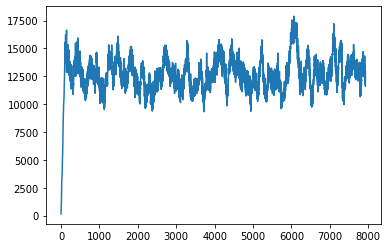

In [16]:
plt.plot(response_times)


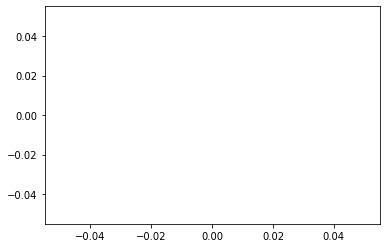

In [17]:
plt.plot(waiting_times)